In [1]:
import numpy as np             
import pandas as pd           #Python Data Analysis Library handle data in a user friendly way
#import random
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import scipy as sc
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols 

# Appendix
## Introduction

In the code below we implement the steps discussed in the main part of the report.

First we introduce the necessary functios for calculating model evidence using Bayesian Linear Regression. For finding the best possible predictors, we use AIC, BIC and Bayesian Model Evidence.

We find the coefficients for linear regression for the best chosen predictors. And perform prediction into the future, up to the year 2030 for the predictors, using corresponding models for them.

We figured out, that the best predictors for our model in terms of AIC/BIC/Model Evidence and common sense are the ```(Petrol+Diesel)``` and ```UK Population```. Using  ```(Petrol+Diesel) = Total_Cars * (1-EV_Fraction)```, we focus on prediction of the ```EV_Fraction``` and ```UK_Population```. We obtain future values for UK population according to the prediction of the Office for National Statistics.

The future values of the ```EV_Fraction``` are obtained from the SI model discussed below. We consider three scenarios for this model:
1) UK predicted scenario with 43% of EV fraction on the road in 2030;

2) Scenario where the current Social Awreness measured in Google trend scores affects the parameter $\lambda$ of the model;

3) Scenario where the UK follows the exact steps which Norway implemented for increasing the usage of the EV in the country in short time.

## Predefine Necessary Functions
##### Bayesian Linear Regression Function

In [2]:
# function for Bayesian Linear regression, return posterior mean and 95% CIs
def BLR(X,y,mu_0,Om_0_inv,a_0,b_0,ind_names,N):
    col_names = ['posterior mean','lower 95% bound','upper 95% bound']
    n,p = X.shape
    XtX = X.T.dot(X)
    Om_n_inv = XtX + Om_0_inv
    Om_n = sc.linalg.inv(Om_n_inv)
    term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
    mu_n = Om_n.dot(term1)
    a_n = a_0 + n/2
    term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))+mu_n.dot(Om_n_inv.dot(mu_n))
    b_n = b_0 + term2/2
    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,p))
    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 =sigma2[i]
        cov = s2*Om_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    results = np.column_stack([mu_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=ind_names)
    return results, mu_n, Om_n, a_n, b_n

##### Model Evidence

In [3]:
# Function for Bayes Model Evidence
def ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0): 
    beta = mu_n
    sigma2 = b_n/(a_n-1)
    Om_0 = sc.linalg.inv(Om_0_inv)
    mu = X.dot(beta)
    cov = sigma2*np.eye(X.shape[0])
    ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
    # evaluate log-prior
    lprior = a_0*np.log(b_0)-sc.special.loggamma(a_0)- (a_0+1)*np.log(sigma2)-b_0/sigma2
    lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
    # evaluate log-posterior
    lpost = a_n*np.log(b_n)-sc.special.loggamma(a_n)- (a_n+1)*np.log(sigma2)-b_n/sigma2
    lpost = lpost + sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)
    lmodevid = ll+lprior-lpost
    return lmodevid

## Linear Regression

In [4]:
data = pd.read_csv('data/GB_all_data.csv')
data = data.set_index('Year')
data = data.fillna(method = 'ffill')
data['EV_fraction'] = data['All_EV']/data['Total_Cars']
data['P_D']=data['Petrol']+data['Diesel']
data['Total_co2']= data['Total_CO2_(NAE_data)']
data['Petrol_fraction']=data['Petrol']/data['Total_Cars']
data.head(3)



,Total_CO2_kilotonne,Total_GHGs_kilotonne,Total_Cars,Total_ULEV_cars,Petrol,Diesel,All_EV,All_ULEV_veh133,ULEV_fraction,UK_Population,Total_Vehicle_km,Average_CO2_(g-km),Average _CO2_cars_first_registered(g-km),Total_CO2_(NAE_data),EV_fraction,P_D,Total_co2,Petrol_fraction
Year,,,,,,,,,,,,,,,,,,
1994,NaN,113648.313,23757800,NaN,19620898.0,1576196.0,93.0,NaN,NaN,57943000.0,4.215000e+11,NaN,NaN,30280.662,0.000004,21197094.0,30280.662,0.825872
1995,NaN,112645.659,23939800,NaN,19499763.0,1891271.0,74.0,NaN,NaN,58095000.0,4.297000e+11,NaN,NaN,29976.864,0.000003,21391034.0,29976.864,0.814533
1996,NaN,116737.339,24841300,NaN,20051602.0,2181634.0,94.0,NaN,NaN,58239000.0,4.411000e+11,NaN,NaN,31146.438,0.000004,22233236.0,31146.438,0.807188


### Standardize the data

In [5]:
mat = np.array(data.T) # obtain an array from the dataframe
std_mat = np.std(mat, axis = 1) # array of standard defviations
mean_mat = np.mean(mat, axis = 1) # array of means

mat_stand = (mat-mean_mat.reshape(-1,1))/std_mat.reshape(-1,1) # standardize the data

standard_data = pd.DataFrame(mat_stand.T, index = data.index, #transfer back to dataframe
                             columns = data.columns)

std_mat = pd.DataFrame(std_mat.reshape(1,-1), 
                             columns = data.columns)

mean_mat = pd.DataFrame(mean_mat.reshape(1,-1), 
                             columns = data.columns)


### Obtain the predictors

Since there are too less samples, we consider juts two predictors for the model. We will consider Bayes Model Evidence as one of the approaches to choose the pair of predictors.

In [6]:
predictors = ['All_EV','EV_fraction','Total_Cars','UK_Population','P_D','Petrol_fraction'] #list of predictors
pairs = [[a,b] for a in predictors for b in predictors if a<b] # split into pairs

mask_train = data.index<2019
# y = standard_data['Total_GHGs_kilotonne'][mask_train]
y = standard_data['Total_co2'][mask_train]
a_0 = 0.1
b_0 = 0.1
N = 10000 #Monte Carlo sample size

K = len(pairs)
Evidence = np.ones(K)

for i in range(K):
    predictors = pairs[i]
    X = standard_data[predictors][mask_train]
    n,p = X.shape
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)   
    Evidence[i] = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)

In [7]:
#Evidence_table
model_evidence = pd.DataFrame([[a,b] for a,b in zip(pairs,Evidence)], 
                              columns = ['Predictors','Evidence']).sort_values('Evidence', axis = 0, 
                                                                               ascending = False)
print('Table for the Model Evidence')
model_evidence.head()

Table for the Model Evidence


,Predictors,Evidence
13,"[Petrol_fraction, Total_Cars]",-39.594235
9,"[Total_Cars, UK_Population]",-39.620303
12,"[P_D, Petrol_fraction]",-39.640187
11,"[P_D, UK_Population]",-39.684615
0,"[All_EV, EV_fraction]",-39.976824


### AIC and BIC for model selection

In [8]:
target = 'Total_co2'
select_list = []

for i in range(K):
    predictors = pairs[i]
    formula="{}~{}".format(target,"+".join(predictors))  
#     print(formula)
    aic=ols(formula=formula,data=standard_data).fit().aic 
    bic=ols(formula=formula,data=standard_data).fit().bic
    formula_select = [formula,aic,bic]
    select_list.append(formula_select)
    print(formula,aic)
min_aic = min([i[1] for i in select_list] )   
min_bic = min([i[2] for i in select_list] )

Total_co2~All_EV+EV_fraction 67.63650100460357
Total_co2~All_EV+Total_Cars 79.72224269316641
Total_co2~All_EV+UK_Population 76.3860738115662
Total_co2~All_EV+P_D 79.70999134756876
Total_co2~All_EV+Petrol_fraction 77.03776140178539
Total_co2~EV_fraction+Total_Cars 79.34884880033474
Total_co2~EV_fraction+UK_Population 76.49369787527468
Total_co2~EV_fraction+P_D 79.33248902803794
Total_co2~EV_fraction+Petrol_fraction 77.0743939118195
Total_co2~Total_Cars+UK_Population 51.879858700370924
Total_co2~P_D+Total_Cars 78.70759150605552
Total_co2~P_D+UK_Population 58.806082560918
Total_co2~P_D+Petrol_fraction 52.29274635982891
Total_co2~Petrol_fraction+Total_Cars 46.87492891198832
Total_co2~Petrol_fraction+UK_Population 76.5192105354318


In [9]:
for i in select_list:
    if i[1] == min_aic:
        print('smallest aic',min_aic,i[0])
    if i[2] == min_bic:
        print('smallest bic',min_bic,i[0])     

smallest aic 46.87492891198832 Total_co2~Petrol_fraction+Total_Cars
smallest bic 50.76243951000131 Total_co2~Petrol_fraction+Total_Cars


## Main model

In [10]:
import statsmodels.api as sm

predictors = ['UK_Population', 'P_D']

y = standard_data['Total_co2']

X = standard_data[predictors]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Total_co2   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     16.99
Date:                Thu, 11 Mar 2021   Prob (F-statistic):           2.53e-05
Time:                        14:00:21   Log-Likelihood:                -26.403
No. Observations:                  27   AIC:                             58.81
Df Residuals:                      24   BIC:                             62.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.203e-15      0.131  -1.68e-14      1.000      -0.271       0.271
UK_Population    -2.2504      0.402     -5.602      0.000      -3.079      -1.421
P_D               1.9151      0.402      4.767      0.000       1.086       2.744
==============================================================================
Omnibus:                        2.384   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.793
Skew:                          -0.461   Prob(JB):                        0.408
Kurtosis:                       2.137   Cond. No.                         5.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## ARIMA Model for Total Cars

For predicting the Petrol+Diesel, we first build ARIMA model for Total cars prediction

<ipython-input-11-e7c2c343b4ef>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


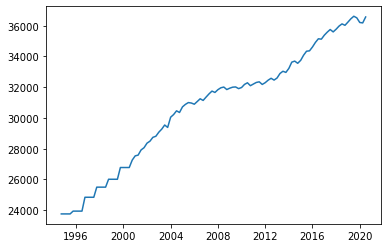

In [11]:
import pandas as pd
import numpy as np
# from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

main = pd.read_csv('data/data_quaterly.csv')


main['time']= pd.to_datetime(main['Quarter'].str.replace(' ','-'))#.replace()pd.to_datetime(df['Quarter'])
main.head()
main = main.set_index('time')
# main[' Cars'] = main[' Cars'].str.replace('..','')
cars = main['Total']
cars = cars.fillna(method = 'ffill').dropna(axis=0)
cars = cars[~cars.isin(['..'])]
cars = cars.astype('float')

plt.plot(cars)


ADF Statistic: -2.719409
p-value: 0.070739


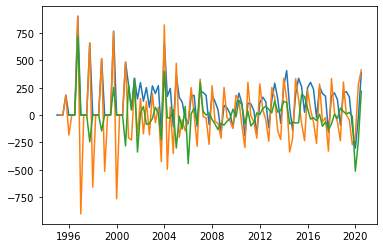

In [12]:
# check the stationarity
from statsmodels.tsa.stattools import adfuller,arma_order_select_ic
from numpy import log
car_diff_4 = cars.diff(4).dropna()
car_diff = cars.diff()[1:]

car_diff_1 = car_diff.diff().dropna()
car_diff_4 = car_diff.diff(4).dropna()
plt.plot(car_diff)
plt.plot(car_diff_1)
plt.plot(car_diff_4)
# print(car_diff)
# print(cars)

result = adfuller(car_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])




The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05).
Thus, we can conclude that the time series is not stationary.

In [13]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(cars, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#Best model:  ARIMA(3,2,0) #p,d,q
#(1,1,0)
arma_order_select_ic(car_diff, max_ar=3, max_ma=3, ic='aic', trend='c', model_kw=None, fit_kw=None)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1381.784, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1385.704, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1385.998, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1384.719, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1417.957, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1383.495, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1386.184, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1384.191, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1382.622, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1355.067, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1356.395, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1358.877, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1370.111, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1358.661, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_mod

{'aic':              0            1            2            3
 0  1385.703520  1385.337291  1385.323147  1374.922242
 1  1386.383252  1386.357004  1387.322954  1362.424260
 2  1383.470142  1384.595223  1355.597960  1360.922279
 3  1379.445912  1360.572526  1346.426309  1341.520726,
 'aic_min_order': (3, 3)}

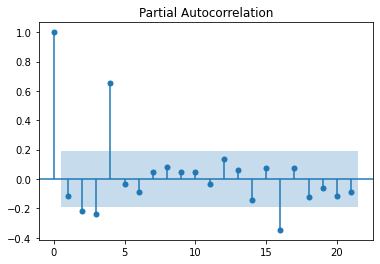

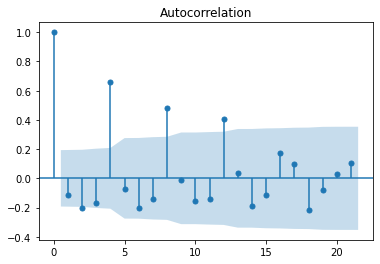

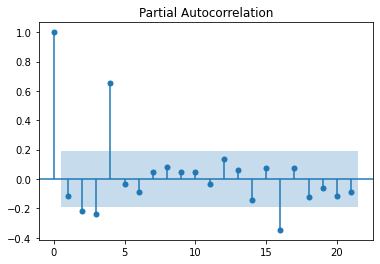

In [14]:
plot_acf(car_diff)
plot_pacf(car_diff)

In [15]:
cars.tail(3)

time
2020-01-01    36210.81
2020-04-01    36183.84
2020-07-01    36568.83
Name: Total, dtype: float64

/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                  103
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.799
Method:                       css-mle   S.D. of innovations            162.766
Date:                Thu, 11 Mar 2021   AIC                           1355.598
Time:                        14:00:28   BIC                           1371.406
Sample:                    01-01-1995   HQIC                          1362.001
                         - 07-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           124.1744     13.461      9.225      0.000      97.791     150.558
ar.L1.D.Total     0.1436      0.049      2.902      0.004       0.047       0.241
ar.L2.D.Total    -0.9499      0.038    -

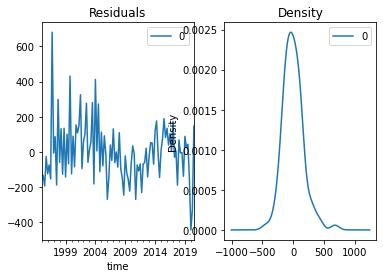

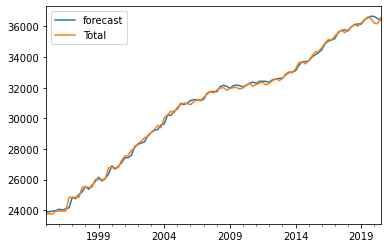

/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                   68
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -459.824
Method:                       css-mle   S.D. of innovations            209.123
Date:                Thu, 11 Mar 2021   AIC                            925.649
Time:                        14:00:29   BIC                            932.307
Sample:                    01-01-1995   HQIC                           928.287
                         - 10-01-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           124.8365     21.444      5.821      0.000      82.807     166.866
ar.L1.D.Total    -0.1857      0.120     -1.544      0.123      -0.421       0.050
                                    Root

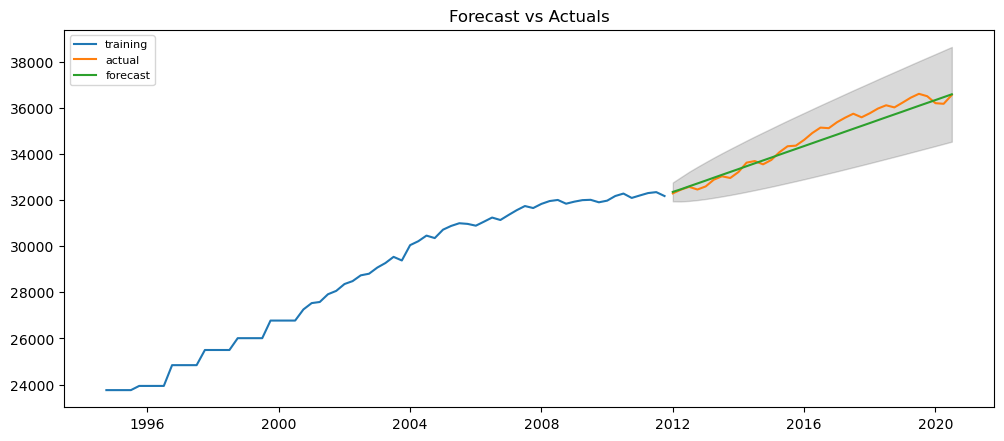

0.8036052265097938

In [16]:
#build the arima
from statsmodels.tsa.arima_model import ARIMA

# 3,2,0 ARIMA Model
model = ARIMA(cars, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#predict
fc, se, conf = model_fit.forecast(4*10, alpha=0.05)  # 95% conf 

#if we spilit the data as training and testing data, and calculate the MAE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test = cars[np.round(2/3*len(cars)).astype(int):]
train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

mean_absolute_percentage_error(test, fc) #7.295545504861874 acceptable (3,2,0)
#if we use model (3,1,0) 0.5138645256869044
#if we use model (0,1,0) 0.5319200544501159

# print(cars.index)

In [17]:
import datetime

def create_assist_date(datestart = None,dateend = None):
	datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
	dateend=datetime.datetime.strptime(dateend,'%Y-%m-%d')
	date_list = []
	date_list.append(datestart.strftime('%Y-%m-%d'))
	while datestart<dateend:
	    datestart+=datetime.timedelta(days = 365/4)
	    date_list.append(datestart.strftime('%Y-%m-%d'))
	return date_list

len(create_assist_date('2020-10-01','2030-10-01'))
new_index = pd.to_datetime(create_assist_date('2020-10-01','2030-09-29')) #2030-12-29 equals to the 2031-01-01
print(new_index)

DatetimeIndex(['2020-10-01', '2020-12-31', '2021-04-01', '2021-07-01',
               '2021-10-01', '2021-12-31', '2022-04-01', '2022-07-01',
               '2022-10-01', '2022-12-31', '2023-04-01', '2023-07-01',
               '2023-10-01', '2023-12-31', '2024-03-31', '2024-06-30',
               '2024-09-30', '2024-12-30', '2025-03-31', '2025-06-30',
               '2025-09-30', '2025-12-30', '2026-03-31', '2026-06-30',
               '2026-09-30', '2026-12-30', '2027-03-31', '2027-06-30',
               '2027-09-30', '2027-12-30', '2028-03-30', '2028-06-29',
               '2028-09-29', '2028-12-29', '2029-03-30', '2029-06-29',
               '2029-09-29', '2029-12-29', '2030-03-30', '2030-06-29',
               '2030-09-29'],
              dtype='datetime64[ns]', freq=None)


/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                  103
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.799
Method:                       css-mle   S.D. of innovations            162.766
Date:                Thu, 11 Mar 2021   AIC                           1355.598
Time:                        14:00:30   BIC                           1371.406
Sample:                    01-01-1995   HQIC                          1362.001
                         - 07-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           124.1744     13.461      9.225      0.000      97.791     150.558
ar.L1.D.Total     0.1436      0.049      2.902      0.004       0.047       0.241
ar.L2.D.Total    -0.9499      0.038    -

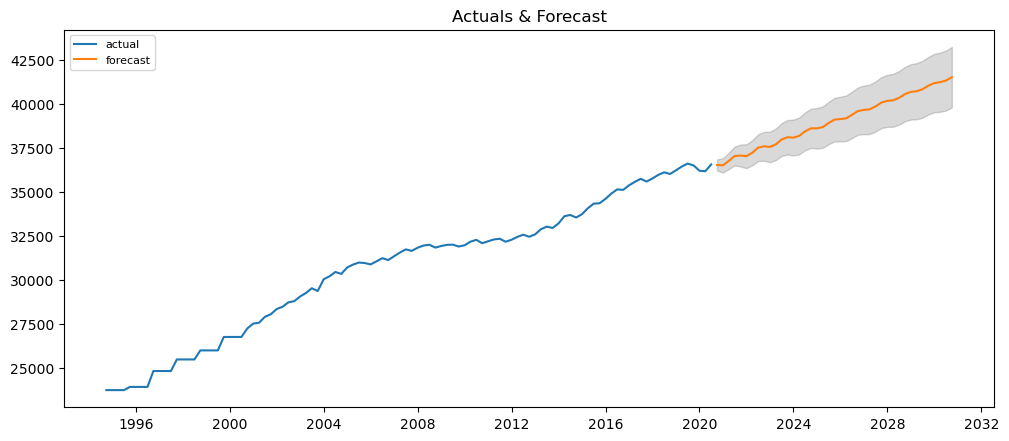

In [18]:
# test = cars[np.round(2/3*len(cars)).astype(int):]
# train = cars[:np.round(2/3*len(cars)).astype(int)]
model = ARIMA(cars, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# model with whole data and Forecast until 2030
fc, se, conf = model_fit.forecast(4*10+1, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=new_index)
lower_series = pd.Series(conf[:, 0], index=new_index)
upper_series = pd.Series(conf[:, 1], index=new_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Actuals & Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#the predicted value of number of cars at the begining of 2030 is 
predict_2030 = fc_series['2029-12-29']

##  Total Cars Prediction until 2030

```fc_year_1``` is the prediction from 2020 Q4 to 2030.

In [19]:
# transform the prediction of number of vehicles from quarterly to yearly

car_num_series = pd.concat([cars.iloc[[-3,-2,-1]],fc_series])

fc_year = []
for i in range(0, len(car_num_series), 4):
    fc_year.append(car_num_series[i:i+4])

fc_year_1 =[np.mean(i) for i in fc_year]

fc_year_1 = pd.DataFrame(fc_year_1)
print(fc_year_1)

               0
0   36375.183716
1   36852.722540
2   37347.097967
3   37841.919033
4   38337.266959
5   38833.161780
6   39329.571967
7   39826.426783
8   40323.629756
9   40821.071910
10  41318.643617


In [20]:
print(cars.tail())

time
2019-07-01    36616.96
2019-10-01    36513.18
2020-01-01    36210.81
2020-04-01    36183.84
2020-07-01    36568.83
Name: Total, dtype: float64


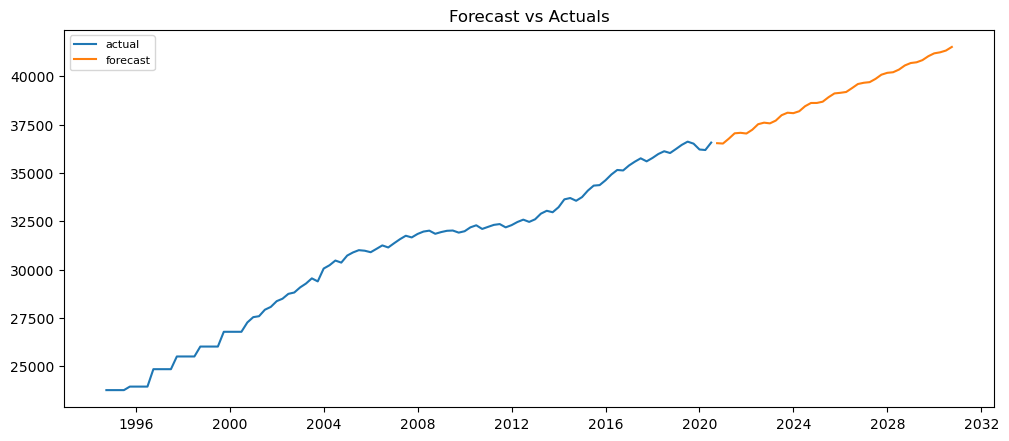

In [21]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ARIMAX try: taking into account COVID19

We use this model to obtain predictions with COVID19. See details in the main body of the report.

refer to https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

https://www.kaggle.com/poiupoiu/how-to-use-sarimax

/Users/firuzamamedova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -685.150
Date:                Thu, 11 Mar 2021   AIC                           1384.300
Time:                        14:00:31   BIC                           1402.743
Sample:                             0   HQIC                          1391.770
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1553   2.69e+04  -5.78e-06      1.000   -5.26e+04    5.26e+04
x1          -326.5778    251.699     -1.297      0.194    -819.899     166.744
ar.L1          0.0460      0.053      0.865      0.3

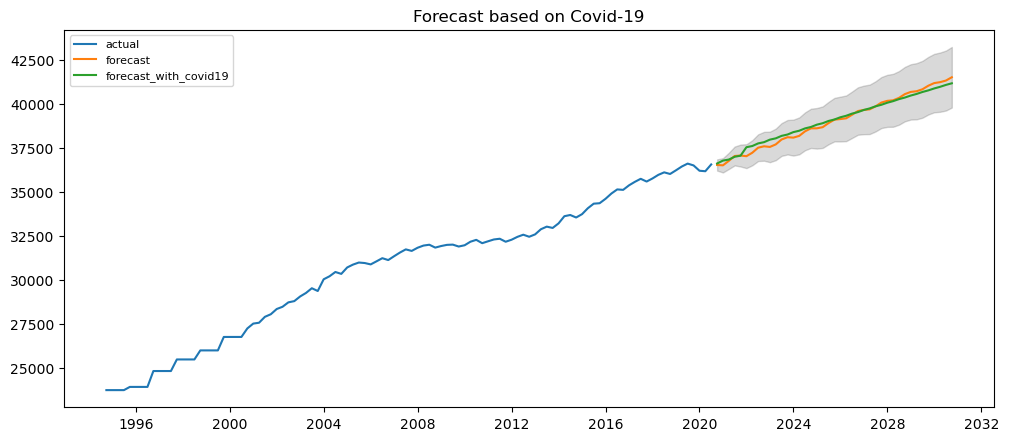

In [22]:
dataAX = pd.DataFrame(data=cars, index=cars.index, columns=['covid'])
dataAX['time']=dataAX.index
# print(data)
#30-01-2020 we assume that it start from the first quarter of 2020 in UK
date_point = pd.to_datetime('2020Q1')

dataAX.loc[(dataAX['time'] >= date_point), 'covid'] = 1;
dataAX.loc[(dataAX['time'] < date_point), 'covid'] = 0;
# print(data)
covid = dataAX['covid']
# print(covid)

#if we assume the covid-19 will affect UK until 2030
covid_future = np.ones([41,2])
# print(covid_future)
# print(pd.DataFrame(np.ones([41,2])))

#if we assume the affect will be be removed from 2021Q4, as the new lock down plan said step four june 2021 remove all legal limits on social contact
covid_positive_future = np.ones([5,2])
a = np.ones([36,1])
b = np.zeros([36,1])
m = np.concatenate((a,b),axis=1)
covid_positive = np.concatenate((covid_positive_future,m),axis=0)


from scipy.stats import norm
from datetime import datetime
import requests
from io import BytesIO
# Variables
endog = cars
exog = sm.add_constant(covid)
endog = np.array(endog, dtype=float)
exog  = np.array(exog , dtype=float)
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(2,1,2))
res = mod.fit(disp=False)
print(res.summary())

fc_covid = res.forecast(exog=covid_future ,steps=4*10+1, alpha=0.05)
# fcast_res2 = res.get_forecast(steps=2)
fc_covid_pos = res.forecast(exog=covid_positive ,steps=4*10+1, alpha=0.05)

# Make as pandas series
fc_series_covid = pd.Series(fc_covid, index=new_index)
fc_series_covid_pos = pd.Series(fc_covid_pos, index=new_index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(cars, label='training')
plt.plot(cars, label='actual')
plt.plot(fc_series, label='forecast')
# plt.plot(fc_series_covid, label='forecast_with_covid19')
plt.plot(fc_series_covid_pos, label='forecast_with_covid19')
# my_x_ticks = time

# plt.xticks(my_x_ticks)

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast based on Covid-19')
plt.legend(loc='upper left', fontsize=8)
plt.show()




# Get the prediction for petrol+diesel 

As mentioned before, we follow a simple formula for predicting the Petrol+Diesel:
$$P_D = 1-EV_{frac},$$
where $EV_{frac}$ is the fraction of electric vehicles on the road.


### Main approach for EV Fraction model: SI-type model

Since the EV fraction of the cars on the road is directly connected to the population, we suppose that it follows SI (Susceptible-Infective) model trend. For example, the same trend one can see for the people owning smartphones.

We can represent this trend as time series which is given by the differential equation:
$$f'(t) = \lambda f(t)(1-f(t)),$$

where $1$ represents the 100% of EVs on the road and $\lambda$ is the "infection" rate. This parameter depends on different factors. We will present two scenarios for the parameter, representing how it can affect the fraction of EV cars on the road and the CO2 emissions derived from it.

By the constraints of the Road to Zero, it is predicted, that there will be 43% of EV on the UK roads by 2030. With this restriction, we found the "infection rate" for the SI model should be $0.506945$. But this model is presenting very optimistic scenario. We also set the infection rate to slowly decrease after the goal of 43% is achieved.

We also created two possible scenarios, where we suggest the factors that affect the infection rate and build the prediction for EV fraction into the future.

In [23]:
infect_rate = 0.507#664 # was just found according to the curve, tried several values
series = np.ones(31,)
series[0] = 0.0102
for t in range(1,31):
    series[t] = infect_rate*series[t-1]*(1-series[t-1])+series[t-1]

series

future_ev_fraction_uk = pd.Series(series, index = range(2020,2051))


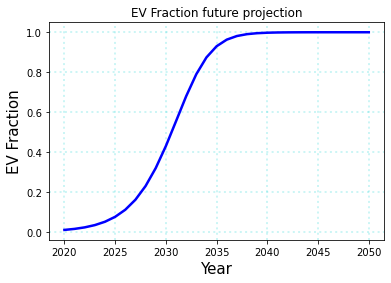

In [24]:
plt.plot(future_ev_fraction_uk,  linewidth=2.5, color = "blue")

plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.xlabel('Year', fontsize=15)
plt.ylabel('EV Fraction', fontsize=15)
plt.title('EV Fraction future projection')

plt.show()


### Petrol + Diesel Predictions

In [25]:
#assumption 1
fraction = data['P_D']/ data['Total_Cars']
fraction_2019 = fraction.loc[2019]
fraction_2030 = (1-0.43)
fraction_future = []
for i in range(11):
    fraction = fraction_2019 + (i+1)*(fraction_2030-fraction_2019)/11
    fraction_future.append(fraction)
    
fraction_future = pd.DataFrame(fraction_future)  
P_D_future = fraction_future*fc_year_1 #fraction_forecast*cars_forecast
print(P_D_future)

               0
0   30055.007998
1   29505.222338
2   28944.011153
3   28357.797144
4   27746.604837
5   27110.407715
6   26449.142534
7   25762.723915
8   25051.057747
9   24314.052354
10  23551.626862


#### UK Optimistic Scenario

In [26]:
# UK scenario
fraction = data['EV_fraction']
fraction_2019 = fraction.loc[2019]
fraction_future_UK =  list(future_ev_fraction_uk)[0:11]

fraction_future = pd.DataFrame(fraction_future_UK)
P_D_future_UK = (1-fraction_future)*fc_year_1
print(P_D_future_UK)

               0
0   36004.156842
1   36288.188519
2   36489.375740
3   36542.325361
4   36376.067236
5   35890.928163
6   34953.411964
7   33398.232554
8   31048.004640
9   27765.378739
10  23546.711493


### Social Networks Impact Model

As the score for the impact we consider current Google trend of different terms connected to the EV: "Electric car", "Electric Vehicle", "Hybrid cars". This trend gives us the infection rate for our SI model.

Since at earlier time steps the model is close to an exponential model (i.e. $f(t) = e^{\lambda t}$), we can find $\lambda$ for each of the terms we have. 


We finally use this parameter $\lambda$ to build another SI model for the trend of EV cars which are affected by the social media. The time series for EV fraction may be then presented in the following way:
$$f'(t) = \lambda f(t)(1-f(t)),$$

In [27]:
df_orig = pd.read_csv('UK_pivotGoogle_orig.csv')
df_orig = df_orig.iloc[:-2]

df_orig = df_orig.set_index('Row Labels')
df_orig.columns = ['Hybrid_cars',
       'Electric_cars',
       'Car_cost',
       'Best_EVs',
       'Electric_vehicles', 'Total']

df_orig['Avg_EV_trend'] = 1/4*(df_orig['Electric_cars'] + df_orig['Hybrid_cars']
                               + df_orig['Best_EVs'] +  df_orig['Electric_vehicles'])#.plot()
df_orig_lambdas  = np.diff(df_orig, prepend = 0, axis = 0)/df_orig.shift(1)
df_orig_lambdas = df_orig_lambdas[df_orig_lambdas>=0]
df_orig_lambdas_column_list = np.nanmean(df_orig_lambdas, axis = 0)


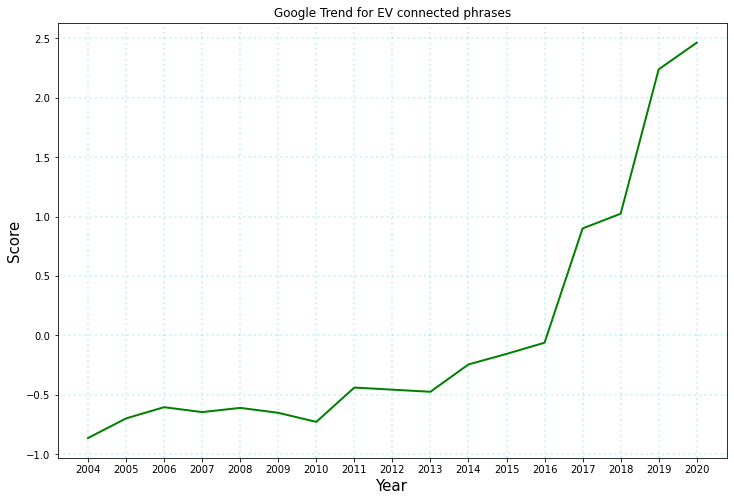

In [28]:
plt.plot((df_orig['Avg_EV_trend']-np.mean(df_orig['Avg_EV_trend']))/np.std(df_orig['Avg_EV_trend']),  linewidth=2, color = "green")
#plt.add_hline(0, 0.087030, linewidth=2 )
plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.xlabel('Year', fontsize=15)
plt.ylabel('Score', fontsize=15)
plt.title('Google Trend for EV connected phrases')
#plt.hlines(0.087030, xmin = 2010, xmax = 2030)
plt.show()

In [29]:
infect_rate = df_orig_lambdas_column_list[-1]
series = np.ones(11,)
series[0] = 0.0102
for t in range(1,11):
    series[t] = infect_rate*series[t-1]*(1-series[t-1])+series[t-1]

future_ev_fraction_SA = pd.Series(series, index = range(2020,2031))


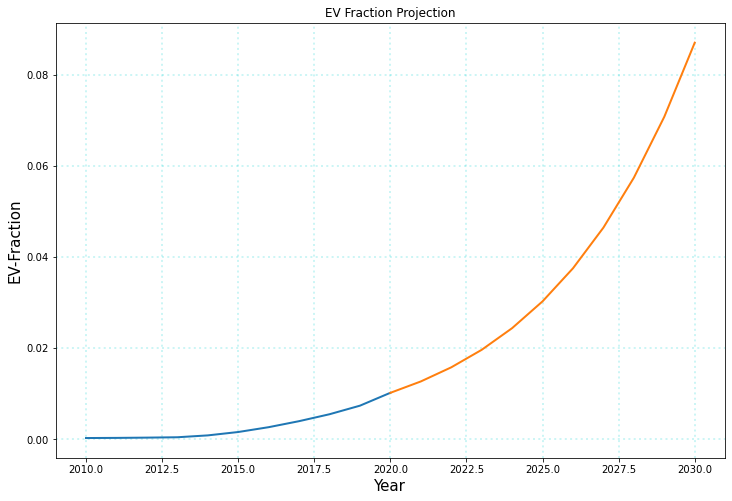

In [30]:
new_data = pd.read_csv('data/GB_all_data.csv')
new_data = new_data.set_index('Year')
past_EV_fraction = new_data['ULEV_fraction']
plt.plot(past_EV_fraction,  linewidth=2)
plt.plot(future_ev_fraction_SA,  linewidth=2)

plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.xlabel('Year', fontsize=15)
plt.ylabel('EV-Fraction', fontsize=15)
plt.title('EV Fraction Projection')

plt.show()

In [31]:
# SA scenario
fraction = data['EV_fraction']
fraction_2019 = fraction.loc[2019]
fraction_future_SA =  list(future_ev_fraction_SA)[0:11]

fraction_future = pd.DataFrame(fraction_future_SA)
P_D_future_SA = (1-fraction_future)*fc_year_1
print(P_D_future_SA)

               0
0   36004.156842
1   36384.870555
2   36757.278294
3   37098.914127
4   37402.154093
5   37657.563982
6   37853.595491
7   37976.276042
8   38008.921778
9   37931.923865
10  37722.686183


### Norway Model

In [33]:
norway = pd.DataFrame([0.1, 0.7, 0.9, 3.2, 5.7, 14.5, 21.1, 26.6,33.6,49.1,55.9,74.7], 
                   index = range(2009,2021),
                    columns = ['EV_fraction'])
norway['EV_fraction'] = norway['EV_fraction']/100
norway['lambdas'] = np.log(norway['EV_fraction']/norway['EV_fraction'].shift(1))#np.diff(norway['EV_fraction'], prepend = 0)/norway['EV_fraction'].shift(1) #equation for finding lambda
norway
infect_rate = norway['lambdas'].copy().iloc[1:] # get the lambda  # change to np.mean to see faster increase
future_ev_NOR = np.ones(11,) # change to 31 for stopping at 2050

future_ev_NOR[0] = 0.015 # the starting 1.5% for EV cars in the UK in 2020
for t in range(1,11): 
    future_ev_NOR[t] = infect_rate.iloc[t]*future_ev_NOR[t-1]*(1-future_ev_NOR[t-1]) + future_ev_NOR[t-1]

future_ev_NOR = pd.Series(future_ev_NOR, index = range(2020,2031)) #change to range(2020,2051) for stopping at 2050

In [34]:
# NOR scenario
fraction = data['EV_fraction']
fraction_2019 = fraction.loc[2019]
fraction_future_NOR =  list(future_ev_NOR)[0:11]

fraction_future = pd.DataFrame(fraction_future_NOR)
P_D_future_NOR = (1-fraction_future)*fc_year_1
print(P_D_future_NOR)

               0
0   35829.555960
1   36163.091253
2   35778.264816
3   35373.138685
4   33653.289260
5   32526.247405
6   31702.740209
7   30648.876388
8   28318.947655
9   27561.288970
10  25270.085575


## Prediction for the Future Population

The population model is an exponential growth model. But we use the values provided by the Office for National Statistics.

In [35]:
population = pd.read_csv('data/UK_population.csv')
population = population.set_index('Year')
# print(population)
mask_population = (population.index<2031) & (population.index>2019)
uk_population = population[mask_population]

#uk_population = uk_population.reset_index(drop=True)

uk_population

,population
Year,
2020,67200000
2021,67500000
2022,67800000
2023,68100000
2024,68400000
2025,68700000
2026,68900000
2027,69200000
2028,69400000


## CO2 prediction with Population and P_D


The formula for linear regression is the following: 

```Total_co2 = -2.2372*UK_Population + 1.9087*P_D```


We assume that:

1. The linear relationship stays unchangeable during the whole period.

2. The number of cars/population keeps the trend into the future (using arima model).




### Standardize the data

Since our model is built using the standardized data, we first standardize the Population and P_D predictions.

In [36]:
beta_UK_Population =  -2.2372
beta_petrol_D = 1.9087

# std_UK_Population = 3.049400e+06#std_mat['Total_co2'].iloc[0]
# mean_UK_Population = 6.197274e+07#.value
# std_petrol_D = 3.000387e+06
# mean_petrol_D = 27041224.0

std_y = std_mat['Total_co2'].iloc[0]
mean_y = mean_mat['Total_co2'].iloc[0]

uk_population_std = np.array((uk_population-np.mean(uk_population))/np.std(uk_population))


In [37]:
# Define the prediction for 2020-2030 function
def prediction(P_D_future):
    
    P_D_future_std = np.array((P_D_future-np.mean(P_D_future))/np.std(P_D_future))

    y = beta_UK_Population*uk_population_std + beta_petrol_D*P_D_future_std

    y_unstandardize = y*std_y + mean_y
    y_unstandardize = pd.DataFrame(y_unstandardize, index = range(2020,2031), columns = ["CO2"])
    decrease = (y_unstandardize["CO2"].iloc[-1]-y_unstandardize["CO2"].iloc[0])/y_unstandardize["CO2"].iloc[0]

    print('Prediction:\n',y_unstandardize)
    print('Decrease for CO2 emissions:', decrease)


In [38]:
# UK Scenario
prediction(P_D_future_UK)

Prediction:
                CO2
2020  35797.222243
2021  35137.069029
2022  34439.261160
2023  33674.075990
2024  32809.256003
2025  31799.497503
2026  30847.207479
2027  29351.091744
2028  27756.692689
2029  25738.497924
2030  23294.851458
Decrease for CO2 emissions: -0.349255333275596


In [39]:
# SA Scenario
prediction(P_D_future_SA)

Prediction:
                CO2
2020  30857.736044
2021  31145.249887
2022  31409.272092
2023  31586.262665
2024  31654.658891
2025  31587.778165
2026  31616.042612
2027  31173.765870
2028  30739.929251
2029  29995.989459
2030  28878.038287
Decrease for CO2 emissions: -0.06415563846865756


In [40]:
# NOR Scenario
prediction(P_D_future_NOR)

Prediction:
                CO2
2020  36612.116771
2021  35997.093332
2022  35006.819953
2023  34005.942643
2024  32318.294566
2025  30940.310820
2026  29983.968173
2027  28644.210367
2028  26900.959723
2029  25979.014300
2030  24255.992574
Decrease for CO2 emissions: -0.33748729345723144
